In [1]:
import random
import time
import pandas as pd
import networkx as nx  
import collections  
import matplotlib.pyplot as plt  
import numpy as np
import scipy.sparse.linalg as linalg

In [2]:
G = nx.read_edgelist('datasets/protein.edgelist.txt')
print(G)

Graph with 2018 nodes and 2930 edges


### A. Tamanho da Rede
O NetworkX oferece funções diretas para obter o número de nós: G.number\_of\_nodes() ou, de forma mais concisa, len(G).

N nós.

In [3]:
num_nodes = G.number_of_nodes()  
print(f"Tamanho da Rede (Número de Nós): {num_nodes} nós")


Tamanho da Rede (Número de Nós): 2018 nós


### B. Número de Links (Arestas)

O NetworkX fornece a função G.number\_of\_edges() para obter o número total de arestas. 
Alternativamente, o método G.size() oferece um resultado idêntico.

M links.

In [4]:
num_edges = G.number_of_edges()  
print(f"Número de Links (Arestas): {num_edges} links")

Número de Links (Arestas): 2930 links


### C. Grau Médio (Average Degree)

O grau médio, ⟨k⟩, é a média do número de conexões por nó na rede, oferecendo um resumo conciso do nível de conectividade geral da rede.

Para redes não direcionadas, o grau médio é calculado como 2M/N, uma vez que cada aresta contribui para o grau de dois nós, ou simplesmente como a soma de todos os graus dividida pelo número de nós.

Em redes direcionadas, o grau médio de entrada (in-degree), o grau médio de saída (out-degree) e o grau total médio são matematicamente equivalentes a M/N

* Cálculo do grau médio para um grafo não direcionado  
* Verifica de o grafo é direcionado G.is_directed()
* Para grafos direcionados, o cálculo seria G.number_of_edges() / G.number_of_nodes()  
* Para grafos não direcionados, o cálculo seria (2 * G.number_of_edges()) / G.number_of_nodes()  

In [5]:
# Cálculo do grau médio para um grafo não direcionado  
# Para grafos direcionados, o cálculo seria G.number_of_edges() / G.number_of_nodes()  
if G.is_directed():  
    avg_degree = G.number_of_edges() / G.number_of_nodes()  
    print(f"Grau Médio (Rede Direcionada): {avg_degree:.2f} passos")  
else:  
    avg_degree = (2 * G.number_of_edges()) / G.number_of_nodes()  
    print(f"Grau Médio (Rede Não Direcionada): {avg_degree:.2f} passos")

Grau Médio (Rede Não Direcionada): 2.90 passos


### D. Distribuição de Graus (Degree Distribution)

A distribuição de graus, P(k), quantifica a probabilidade de um nó selecionado aleatoriamente na rede ter exatamente k conexões.

Metodologia de Cálculo e Visualização:  

O processo de cálculo envolve primeiro a obtenção do grau (ou in-degree/out-degree para grafos direcionados) de cada nó na rede. Em seguida, a frequência de cada valor de grau único é contada para construir a distribuição.

#### Código

##### Montagem dados para gráfico

* Calcula e organiza os dados de graus do seu grafo, 
  * obtém uma lista de pares (nó, grau) para cada nó no grafo,  
  * que extrai apenas o valor do grau (d) de cada par, 
  * Ordena essa lista de graus em ordem decrescente. 
  * O resultado é uma lista chamada degree_sequence que contém os graus de todos os nós do grafo, do maior para o menor.
* A classe **collections.Counter** é uma maneira de contar a frequência de itens em uma lista.
  * Cria um dicionário onde as chaves são os graus (k) e os valores são o número de nós que têm esse grau. Ex.: se 10 nós têm grau 3, o dicionário terá a entrada {3: 10}
* Gerando duas tuplas com os graus unicos, e das contagens corespondentes.
  * Descompacta o dicionário com '*' pegando os items de gedree_counts, e a função zip gerando uma lista de tuplas com grau (deg) e contagem(cnt).

##### Preparando dados

* Seleciona apenas as contagens que são maiores que zero. Isso evita erros de cálculo.

##### Historograma
* Este histograma mostra quantos nós existem para cada grau possível no grafo.

##### Distribuição
* O principal objetivo é identificar a distribuição de graus por número de nós.


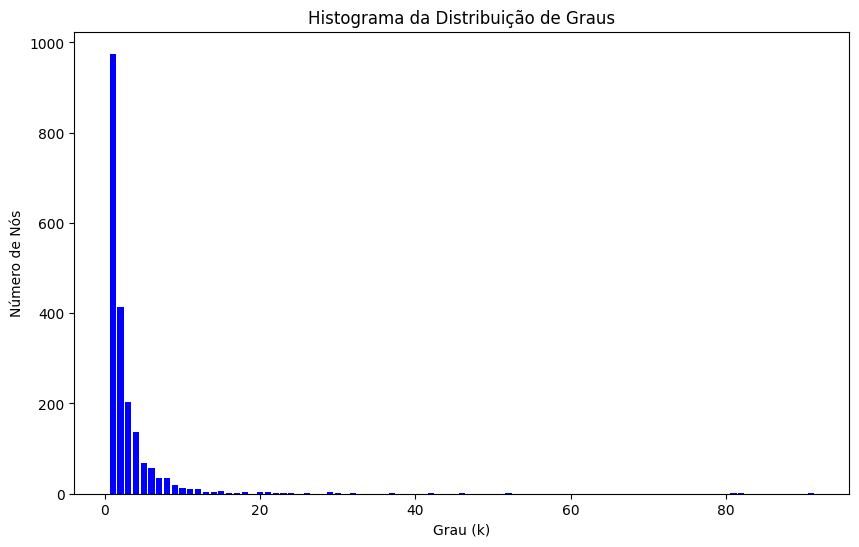

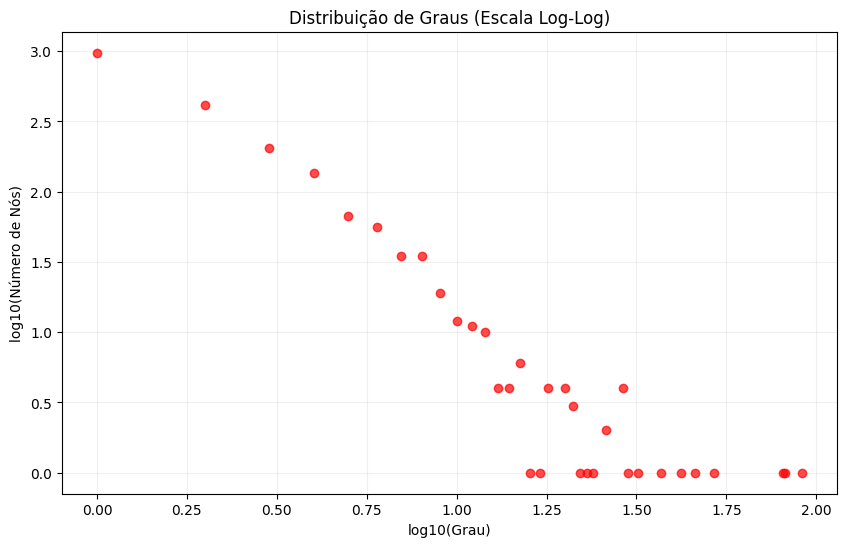

In [6]:
# Monata uma lista com os graus dos nós em ordem decrescente.

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_counts = collections.Counter(degree_sequence)  
deg, cnt = zip(*degree_counts.items())

# Filtrar contagens zero para o gráfico log-log (logaritmo de zero é indefinido)  
positive_cnt_indices = np.array(cnt) > 0  
logx = np.log10(np.array(deg)[positive_cnt_indices])  
logy = np.log10(np.array(cnt)[positive_cnt_indices])

# Histogram Plot  
plt.figure(figsize=(10, 6))  
plt.bar(deg, cnt, width=0.8, color='b')  
plt.title("Histograma da Distribuição de Graus")  
plt.xlabel("Grau (k)")  
plt.ylabel("Número de Nós")  
plt.show()

# Log-Log Plot  
plt.figure(figsize=(10, 6))  
plt.plot(logx, logy, 'o', color='r', alpha=0.7)  
plt.title("Distribuição de Graus (Escala Log-Log)")  
plt.xlabel("log10(Grau)")  
plt.ylabel("log10(Número de Nós)")  
plt.grid(True, which="both", ls="-", alpha=0.2)  
plt.show()

### E. Média das Distâncias entre Pares (Average Shortest Path Length)

A média das distâncias entre pares (ASPL), denotada como ⟨L⟩, é definida como o número médio de passos (arestas) ao longo dos caminhos mais curtos para todos os pares possíveis de nós na rede. Serve como uma medida crucial da eficiência da rede no transporte de informações ou massa. Um ASPL menor geralmente indica uma rede mais eficiente, interconectada e facilmente navegável, onde a informação pode viajar rapidamente entre quaisquer dois pontos.

#### Código

* A função media_distancias_entre_pares calcula a média das distâncias de caminho mais curto entre todos os pares de nós em um grafo. Ela foi projetada para lidar com dois cenários: quando o grafo é conectado e quando ele é desconectado.
  * Grafo Conectado
    * calcula direto utilizando a função nx.average_shortest_path_length()

  * Grafo Desconectado
    * Como não é possível calcular a distância entre nós que não estão no mesmo componente, é calculado o maior componente conectado.
    * Faz o calculo da função nx.average_shortest_path_length() com o maior componente conectado.



In [7]:
def media_distancias_entre_pares(lcc_):
    """Média das Distâncias entre Pares"""

    if nx.is_connected(lcc_):        
        print("A rede é conectada.")
        avg_path_length_estimate = nx.average_shortest_path_length(lcc_)   
        return print(f"Média das Distâncias entre Pares: {avg_path_length_estimate:.2f} passos")  
    else:  
        print("A rede é desconectada.")        
        componentes = nx.connected_components(lcc_)
        maior_comp_nodes = max(componentes, key=len)
        
        print('Cria um subgrafo com o MAX correspondente para analise')
        componente_maior = lcc_.subgraph(maior_comp_nodes).copy()
        
        print(f"Novo subgrafo criado com {componente_maior.number_of_nodes()} nós e {componente_maior.number_of_edges()} arestas.")
        avg_path_length_estimate = nx.average_shortest_path_length(componente_maior)
        return print(f"Média das Distâncias entre Pares: {avg_path_length_estimate:.2f} passos")

### Amostragem

* É criado um subgrado com 20% do grafo original, como amostragem, para diminuir o tempo de processamento da função media_distancias_entre_pares.

  * Criar o subgrafo a partir da lista de nós
    * Usar .copy() para ter um grafo independente
  * Criando amostragem 20% dos Nós do LCC
    * Pega a lista de todos os nós que estão no LCC
    * Calcula quantos nós correspondem a 20% do LCC
    * Usamos int() para garantir que o resultado seja um número inteiro
    * Seleciona aleatoriamente 'num_nodes_to_sample' nós da lista, sem reposição
  * Criar o Subgrafo Final com os 20% dos Nós
    * Cria o subgrafo final a partir do LCC, usando apenas os nós amostrados
    * Este novo grafo conterá os nós amostrados e TODAS as arestas que existiam ENTRE ELES no LCC

In [8]:
lcc_nodes = list(max(nx.connected_components(G), key=len)) 

# Criando Subgrafo 

LCC_subgraph = G.subgraph(lcc_nodes).copy() 
print(f"Número de nós no grafo original (G): {G.number_of_nodes()}")
print(f"Número de nós no Maior Componente Conectado (LCC): {LCC_subgraph.number_of_nodes()}")
print("-" * 30)

# Criando Amostragem 

lcc_node_list = list(LCC_subgraph.nodes())
num_nodes_to_sample = int(LCC_subgraph.number_of_nodes() * 0.20)
sampled_nodes = random.sample(lcc_node_list, k=num_nodes_to_sample)
print(f"Vamos amostrar 20% do LCC, o que corresponde a {num_nodes_to_sample} nós.")
print("-" * 30)

# Subgrafo Final com os 20% dos Nós

LCC_20_percent = LCC_subgraph.subgraph(sampled_nodes).copy()
print(f"Novo subgrafo criado com {LCC_20_percent.number_of_nodes()} nós e {LCC_20_percent.number_of_edges()} arestas.")

inicio_par = time.time()

media_distancias_entre_pares(LCC_20_percent)
fim_par = time.time()
print(f"Tempo de execução paralela: {(fim_par - inicio_par)/60:.4f} minutos")

Número de nós no grafo original (G): 2018
Número de nós no Maior Componente Conectado (LCC): 1647
------------------------------
Vamos amostrar 20% do LCC, o que corresponde a 329 nós.
------------------------------
Novo subgrafo criado com 329 nós e 104 arestas.
A rede é desconectada.
Cria um subgrafo com o MAX correspondente para analise
Novo subgrafo criado com 12 nós e 13 arestas.
Média das Distâncias entre Pares: 2.58 passos
Tempo de execução paralela: 0.0000 minutos


### F. Diâmetro da Rede (Diameter)

O diâmetro de uma rede é definido como o caminho mais curto mais longo entre quaisquer dois nós na rede. Ele representa a separação máxima ou a "distância" que a informação ou influência deve percorrer dentro da rede. É uma métrica crítica para entender a compactação geral da rede, sua eficiência e potenciais gargalos. Um diâmetro menor geralmente indica uma rede mais interconectada e eficiente.

In [9]:
lcc_ = nx.subgraph(G, lcc_nodes)

def diametro(lcc_):
    """Média das Distâncias entre Pares"""

    if nx.is_connected(lcc_):        
        print("A rede é conectada.")
        diam_estimate = nx.diameter(lcc_)
        return print(f"Estimativa do Diâmetro da Rede: {diam_estimate:.2f}")  
    else:  
        print("A rede é desconectada. O diâmetro é indefinido para a rede completa. Calculando para o maior componente conectado.")  
        largest_cc = max(nx.connected_components(lcc_), key=len)  
        subgraph_lcc = lcc_.subgraph(largest_cc).copy()  
        if len(subgraph_lcc) > 1:  
            diameter_lcc = nx.diameter(subgraph_lcc)  
            print(f"  Diâmetro do Maior Componente Conectado (N={len(subgraph_lcc)}): {diameter_lcc} passos")  
        else:  
            print("O maior componente conectado possui apenas um nó; diâmetro não aplicável.")
       

print(diametro(LCC_20_percent))

A rede é desconectada. O diâmetro é indefinido para a rede completa. Calculando para o maior componente conectado.
  Diâmetro do Maior Componente Conectado (N=12): 5 passos
None


### G. Escolher uma rede das 10 redes empiricas e calcular a centradilidade dos nodos usando: Autovetor, Katz, PageRank, Betwenness. Calcular a media delas assim como plotar o histograma.

* Escolhida a rede phonecalls

#### Centradilidade Autovetor.

Mede a influência de um vertice na rede. atravez de dois fatores:

* Seu grau 
* Importância dos seus vizinhos.

In [10]:
eigenvector_centrality = nx.eigenvector_centrality(lcc_)

### Centradilidade Katz.

Tem o mesmo principio do autovetor, porem, a diferença é que, inicialmente, defini-se uma pequena quantidade de centralidade para cada vértice da rede.

Apresentou o segunte erro:

erro: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

Aprendido: A centralidade de Katz não é calculada com uma fórmula simples e direta. Em vez disso, ela é encontrada usando um processo iterativo chamado Iteração de Potência (Power Iteration). O algoritmo começa com uma estimativa inicial para os scores de centralidade e refina essa estimativa repetidamente a cada passo (ou "iteração"). Ele para quando os scores mudam muito pouco entre uma iteração e a seguinte (o que significa que eles "convergiram" para uma solução).

#### Código

Solucionando erro **power iteration failed to converge** definindo um alpha menor que já que o valor padrão de 1 não atendeu e apresentou esse erro.

* Obtenha a matriz de adjacência em um formato que o SciPy
  * Use to_scipy_sparse_array para versões mais novas do NetworkX
* Calcule o maior autovalor (raio espectral)
  * k=1 significa que queremos o maior. 'LM' significa 'Largest Magnitude' (maior magnitude).
  * O resultado é um array, então pegamos o primeiro elemento.
  * Usamos a parte real para evitar pequenos componentes e problemas de precisão numérica.
* Definindo o alpha
  * um pouco menor que seu máximo teórico
  * Usando 99% do valor máximo por segurança


In [12]:
# Obtenha a matriz de adjacência em um formato que o SciPy

A = nx.to_scipy_sparse_array(lcc_, nodelist=lcc_.nodes())

# Calculo do maior autovalor (raio espectral)

raio_espectral = np.real(linalg.eigs(A, k=1, which='LM')[0][0])

# O alpha

alpha = (1 / raio_espectral) * 0.99  
print(f"Raio Espectral Calculado: {raio_espectral:.4f}")
print(f"Alpha seguro para usar: {alpha:.4f}")

# 4. Rode novamente a centralidade de Katz com o alpha calculado para maixo de 1000 iterações.

katz_centrality = nx.katz_centrality(lcc_, alpha=alpha, max_iter=10000) 


Raio Espectral Calculado: 13.4897
Alpha seguro para usar: 0.0734


### Centradilidade PageRank.

In [13]:
pagerank_centrality = nx.pagerank(lcc_)

### Centradilidade Betwenness.

In [14]:
betweenness_centrality = nx.betweenness_centrality(lcc_, k=100)

### Visualização e Organização dos dados das Centralidades

* Organização dos Dados e Cálculo da Média
  * Criando um DataFrame do pandas para melhor visualização e manipulação
  * Calculando a média das quatro medidas de centralidade para cada nodo
  * Ordenando os resultados pela média para facilitar a interpretação
    * Arredondando para 4 casas decimais
    * imprimindo o head do dataframe

In [15]:
# Criando um DataFrame do pandas

df_centrality = pd.DataFrame({
    'Autovetor': pd.Series(eigenvector_centrality),
    'Katz': pd.Series(katz_centrality),
    'PageRank': pd.Series(pagerank_centrality),
    'Betweenness': pd.Series(betweenness_centrality)
})

# Calculando a média
df_centrality['Média'] = df_centrality.mean(axis=1)

# Ordenando os resultados
df_centrality_sorted = df_centrality.sort_values(by='Média', ascending=False)


# Resultado
print("Tabela de Centralidades dos Nodos:")
print(df_centrality_sorted.round(4).head()) 

Tabela de Centralidades dos Nodos:
      Autovetor    Katz  PageRank  Betweenness   Média
1356     0.4655  0.4593    0.0123       0.2827  0.3049
1637     0.3216  0.3186    0.0115       0.1599  0.2029
1400     0.1819  0.1870    0.0125       0.2517  0.1583
161      0.2152  0.2126    0.0054       0.0519  0.1213
1888     0.1984  0.1955    0.0037       0.0201  0.1044


Foram feita algumas configurações para histograma

* Histograma
  * Configurando o estilo do plot usando seaborn-v0_8-whitegrid
  * Configurado histograma para 100 bins , color e edgecolor que se destacam com o estilo escolhido. Utilizando logaritmo no eixo y para melhorar a visualização.
  * Adicionando títulos e legendas correspondentes as médias centralizadas.
  * Exibindo o gráfico

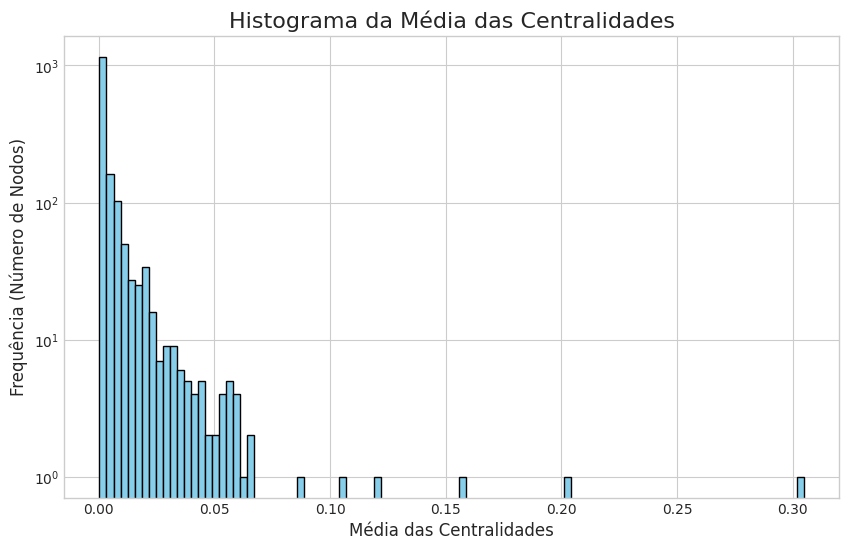

In [16]:
# Plot do Histograma
# Configurando o estilo do plot
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 6))
plt.hist(df_centrality['Média'], bins=100, color='skyblue', edgecolor='black')

# Adicionando títulos e legendas
plt.title('Histograma da Média das Centralidades', fontsize=16)
plt.xlabel('Média das Centralidades', fontsize=12)
plt.ylabel('Frequência (Número de Nodos)', fontsize=12)
plt.yscale('log')

# Exibindo o gráfico
plt.show()



### Desenhar o subgrafo com os 1000 nodos com maior PageRank. 

A cor do nodo deve representar o seu valor de PageRank. Usar a rede do item (g).


* Convertendo o dicionário para uma Series do pandas para facilitar a ordenação    
* Ordenando os nodos pelo valor de PageRank em ordem decrescente e pegando os 1000 primeiros
* Criação do Subgrafo
  * Criando o subgrafo que contém apenas os nodos da lista top_1000_nodes
* Visualização do Subgrafo
  * Usando um fundo escuro para destacar as cores
* Posição dos nodos para a visualização (pode demorar um pouco para 1000 nodos)
* O layout 'spring' trata os nodos como massas e as arestas como molas
* Pegando os valores de PageRank apenas para os nodos do subgrafo
* Desenhando o grafo
  * Usando um mapa de cores vibrante (plasma)
* Adicionando uma barra de cores para mapear cores a valores de PageRank
* Configurações finais do plot
  * Remove os eixos

Top 1000 nodos com maior PageRank identificados.
Subgrafo criado com 1000 nodos e 2029 arestas.
Preparando a visualização do subgrafo...
Plot gerado. Exibindo a imagem...


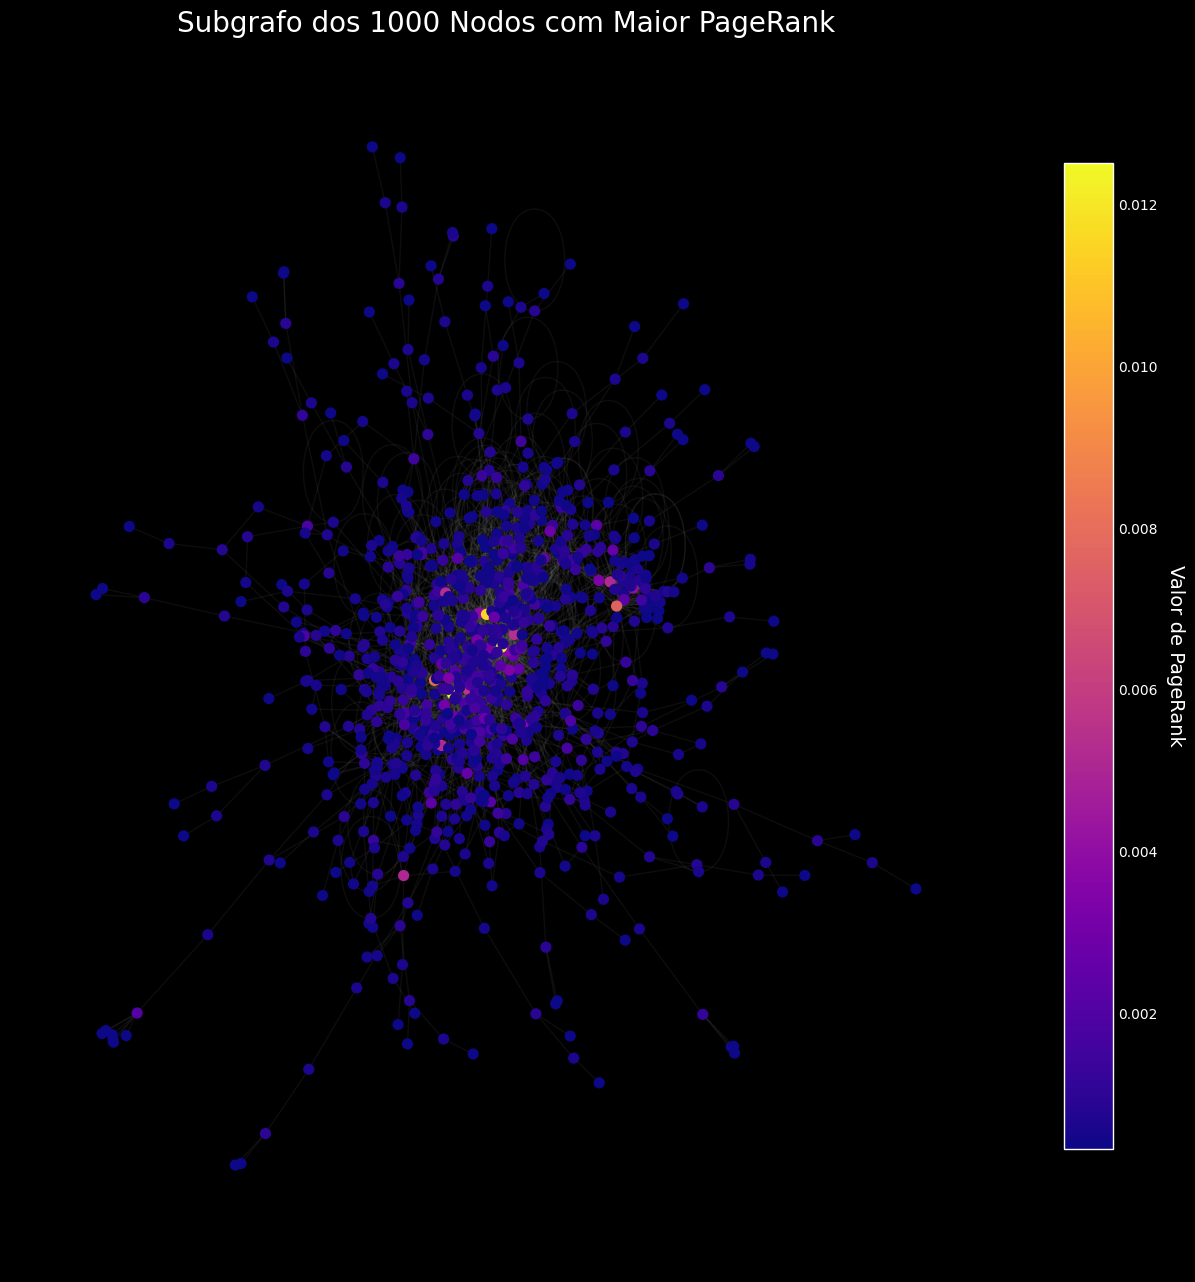

In [17]:

# Convertendo o dicionário para uma Series do pandas para facilitar a ordenação
pagerank_series = pd.Series(pagerank_centrality)

# Ordenando os nodos pelo valor de PageRank em ordem decrescente e pegando os 1000 primeiros
top_1000_nodes = pagerank_series.nlargest(1000).index.tolist()
print("Top 1000 nodos com maior PageRank identificados.")

# --- Criação do Subgrafo ---
# Criando o subgrafo que contém apenas os nodos da lista top_1000_nodes
S = G.subgraph(top_1000_nodes)
print(f"Subgrafo criado com {S.number_of_nodes()} nodos e {S.number_of_edges()} arestas.")

# --- Visualização do Subgrafo ---
print("Preparando a visualização do subgrafo...")
plt.style.use('dark_background') # Usando um fundo escuro para destacar as cores
fig, ax = plt.subplots(figsize=(16, 16))

# Posição dos nodos para a visualização (pode demorar um pouco para 1000 nodos)
# O layout 'spring' trata os nodos como massas e as arestas como molas
pos = nx.spring_layout(S, seed=42, iterations=50)

# Pegando os valores de PageRank apenas para os nodos do subgrafo
node_colors = [pagerank_centrality[node] for node in S.nodes()]

# Desenhando o grafo
nodes = nx.draw_networkx_nodes(
    S,
    pos,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.plasma # Usando um mapa de cores vibrante (plasma)
)
edges = nx.draw_networkx_edges(S, pos, alpha=0.1, edge_color='gray')

# Adicionando uma barra de cores para mapear cores a valores de PageRank
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Valor de PageRank', rotation=270, labelpad=20, fontsize=14)

# Configurações finais do plot
ax.set_title('Subgrafo dos 1000 Nodos com Maior PageRank', fontsize=20)
plt.axis('off') # Remove os eixos
print("Plot gerado. Exibindo a imagem...")
plt.show()